# <a id='toc1_'></a>[Snowmelt timing for select HCDN Basins](#toc0_)

Author: Daniel Hogan

Created: October 18, 2023

This notebook will derive the median date of snow disappearnce for select HCDN basins in our analysis. This information is used in Figure 4 to show that higher elevation basins have later snowmelt timing. This information is derived from snowmelt timing maps over North America generated from MODIS imagery spanning 2001-2018. Data was acquired from: https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1712

**Table of contents**<a id='toc0_'></a>    
- [Snowmelt timing for select HCDN Basins](#toc1_)    
    - [Imports](#toc1_1_1_)    
    - [Grab stations of interest for analysis](#toc1_1_2_)    
- [Get mean snowmelt timing map](#toc2_)    
    - [Plot what timing looks like](#toc2_1_1_)    
    - [Save stats to a file](#toc2_1_2_)    
    - [Comparing to SNTL site values for validation](#toc2_1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Imports](#toc0_)

In [2]:
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np

### <a id='toc1_1_2_'></a>[Grab stations of interest for analysis](#toc0_)

In [4]:
# import basin boundaries
hcdn_basins = gpd.read_file('../data/geodata/ucrb_selected_basins.geojson')
# create a filter to select only the basin of interest
basin_filter = hcdn_basins['STAID'].isin(['09166500','09112500','09035900'])
# apply the filter
example_basins = hcdn_basins[basin_filter]
# check the crs 
print(example_basins.crs)
# write the crs to 32613
example_basins = example_basins.set_crs(32613, allow_override=True)
# check the crs again
print(example_basins.crs)


EPSG:32613
EPSG:32613


In [5]:
example_basins

,AREA,PERIMETER,GAGE_ID,STAID,STANAME,DRAIN_SQKM,HUC02,LAT_GAGE,LNG_GAGE,STATE,...,OLD_HCDN,NSIP_SENTINEL,FIPS_SITE,COUNTYNAME_SITE,NAWQA_SUID,mean_elevation,max_elevation,min_elevation,elevation_category,geometry
8,7.489830e+08,194640.0,09112500,09112500,EAST RIVER AT ALMONT CO.,749.0,14,38.664437,-106.848095,CO,...,yes,None,8051,Gunnison,None,3130.096436,4256.691895,2445.432617,medium,"POLYGON ((322722.350 4319575.206, 322719.501 4..."
11,1.306860e+09,298500.0,09166500,09166500,"DOLORES RIVER AT DOLORES, CO.",1306.9,14,37.472493,-108.497591,CO,...,None,None,8083,Montezuma,None,2954.165039,4276.498047,2118.463135,low,"POLYGON ((208055.589 4190759.362, 208052.721 4..."
20,7.284210e+07,44473.9,09035900,09035900,"SOUTH FORK OF WILLIAMS FORK NEAR LEAL, CO.",72.8,14,39.795820,-106.030573,CO,...,None,None,8049,Grand,ucol,3349.014648,3942.364990,2738.181641,high,"POLYGON ((407918.390 4404316.453, 407919.598 4..."


# <a id='toc2_'></a>[Get mean snowmelt timing map](#toc0_)

In [6]:
# Now lets open the mean imagery for snowmelt timing
# open the mean snowmelt image
mean_snowmelt = rxr.open_rasterio('../data/snowdata/Snowmelt_Timing_North_America_Mean_2001_2018_V2.tif', masked=True).squeeze()
# reproject the image to the basin crs
mean_snowmelt = mean_snowmelt.rio.reproject(example_basins.crs)


### <a id='toc2_1_1_'></a>[Plot what timing looks like](#toc0_)

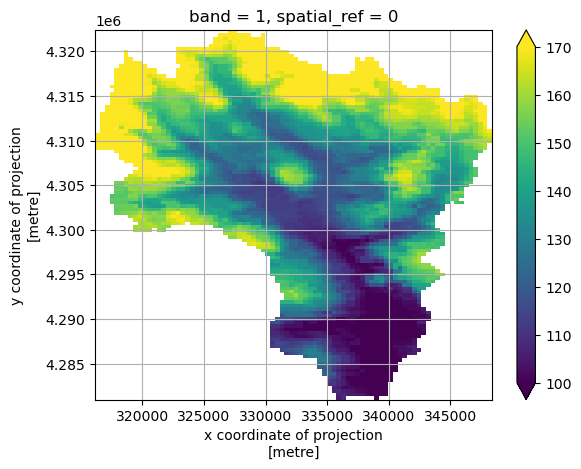

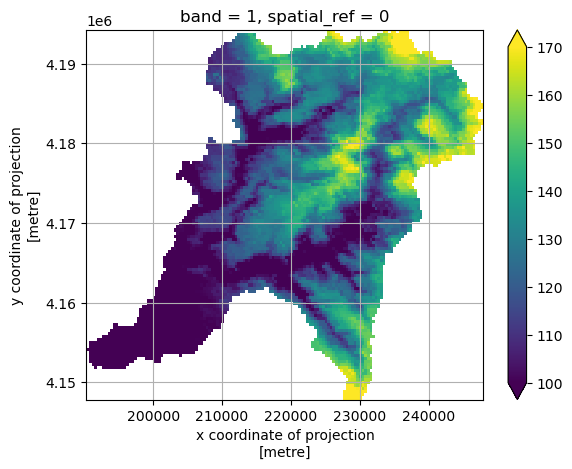

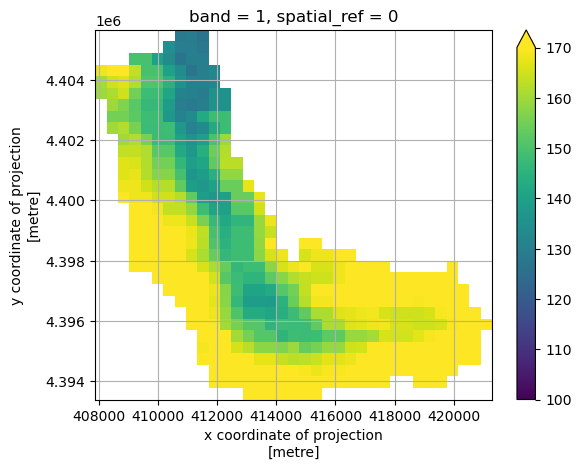

In [8]:
# create and empty dataframe with mean, median, and std columns 
basin_stats = pd.DataFrame(columns=['mean','median','std'], index=example_basins['STAID'])
# clip the image to the first basin in example_basins
for site in example_basins['STAID']:
    mean_snowmelt_clip = mean_snowmelt.rio.clip(example_basins[example_basins['STAID']==site].geometry, example_basins.crs, drop=True)
    # filter values below 100
    # mean_snowmelt_clip = mean_snowmelt_clip.where(mean_snowmelt_clip>90)
    # add values to basin_stats
    basin_stats.loc[site] = [mean_snowmelt_clip.mean().values, mean_snowmelt_clip.median().values, mean_snowmelt_clip.std().values]
    fig, ax = plt.subplots()
    mean_snowmelt_clip.plot(ax=ax,vmin=100, vmax=170)
    ax.grid()

### <a id='toc2_1_2_'></a>[Save stats to a file](#toc0_)

In [ ]:
# save basin_stats
basin_stats.to_csv('../data/snowdata/example_basin_snow_stats.csv')

### <a id='toc2_1_3_'></a>[Comparing to SNTL site values for validation](#toc0_)

In [67]:
# open ucrb_hcdn_sntl_all_20220930.nc
ds = xr.open_dataset('../data/snowdata/ucrb_hcdn_sntl_all_20220930.nc')
example_sntl = ds.sel(Location=' 380:CO:SNTL')['WTEQ']
melt_timing = np.zeros(len(example_sntl.Date.dt.year.to_pandas().unique()))
for i,year in enumerate(example_sntl.Date.dt.year.to_pandas().unique()):
    tmp = example_sntl.where(example_sntl.Date.dt.year==year, drop=True)
    # calculate the 7 day rolling mean of wteq
    tmp_7day = tmp.rolling(Date=7, center=True).mean()
    # make values less than 0 equal to 0 but keep nans
    tmp_7day = tmp_7day.where((tmp_7day>0) | (tmp_7day.isnull()), 0)
    # drop values greater than 220
    # tmp_7day = tmp_7day.where(tmp_7day<220, 0)

    # print the day of year of the first zero value
    if tmp_7day.idxmin(dim='Date').dt.dayofyear.values > 210:
        melt_timing[i] = np.nan
    else:
        melt_timing[i] = (tmp_7day.idxmin(dim='Date').dt.dayofyear.values)

In [ ]:
print(melt_timing)